In [1]:
import os
import h5py
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

import utils_CNN as utils

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-10-09 13:32:33.070224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 13:32:33.150247: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Compute sample size before CNN cut

In [2]:
sample_dir = Path('../Sample/HVmodel/data/')

results_b = np.load(sample_dir / 'selection_results_SB_4400_5800_b.npy', allow_pickle=True).item()
results_s = np.load(sample_dir / 'selection_results_SB_4400_5800_s.npy', allow_pickle=True).item()

In [3]:
# Total cross section and number of events
xection, tot_event = utils.get_cross_section_and_nevent('../Sample/ppjj/Events/run_03')
print(xection, tot_event)

# cross section in signal region and sideband region
cross_section_SR = results_b['cutflow_number']['Signal region'] / results_b['cutflow_number']['Total'] * xection
cross_section_SB = results_b['cutflow_number']['Sideband region'] / results_b['cutflow_number']['Total'] * xection
cross_section_eta = results_b['cutflow_number']['jet eta cut'] / results_b['cutflow_number']['Total'] * xection
print(f'Background cross section, SR: {cross_section_SR:.2f} fb, SB: {cross_section_SB:.2f} fb')

# number of background events in signal region and sideband region
L = 139 * 1
n_SR_B = cross_section_SR * L
n_SB_B = cross_section_SB * L
n_eta_B = cross_section_eta * L

print(f'Background sample size: SR: {n_SR_B:.1f}, SB: {n_SB_B:.1f}')

sensitivity = 1
n_SR_S = sensitivity * np.sqrt(n_SR_B)
n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']
n_eta_S = n_SR_S * results_s['cutflow_number']['jet eta cut'] / results_s['cutflow_number']['Signal region']
print(f'Signal sample size: SR: {n_SR_S:.1f}, SB: {n_SB_S:.1f}')

print(f'Sample size after eta cut: B: {n_eta_B:.1f}, S: {n_eta_S:.1f}')

6837.392481 1000000
Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 137.6, SB: 33.5
Sample size after eta cut: B: 527689.2, S: 221.2


# Load testing datasets

In [20]:
h5_path = sample_dir / 'split_val/mix_sample_test-mjj.h5'
with h5py.File(h5_path, 'r') as f:
    mjj = f['EVENT/Mjj'][:]
    eta1 = f['J1/eta'][:]
    eta2 = f['J2/eta'][:]
    pt1 = f['J1/pt'][:]
    pt2 = f['J2/pt'][:]

    jet1_eta = (eta1 * pt1).sum(axis=1) / pt1.sum(axis=1)
    jet2_eta = (eta2 * pt2).sum(axis=1) / pt2.sum(axis=1)

    deta = jet1_eta - jet2_eta

# load jet image from npy file
res = 25
npy_path = sample_dir / f'split_val/{res}x{res}/mix_sample_test-mjj.h5'
X, y = utils.load_samples(npy_path)

mjj_b = mjj[y == 0]
mjj_s = mjj[y == 1]

deta_b = deta[y == 0]
deta_s = deta[y == 1]

deta_b_SR = deta_b[(mjj_b > 4400) & (mjj_b < 5800)]
deta_s_SR = deta_s[(mjj_s > 4400) & (mjj_s < 5800)]
deta_b_SB = deta_b[(mjj_b < 4400) | (mjj_b > 5800)]
deta_s_SB = deta_s[(mjj_s < 4400) | (mjj_s > 5800)]

# Plot $m_{jj}$ distribution before CNN cut

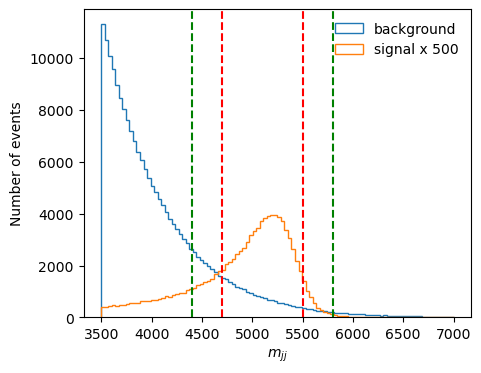

In [5]:
# plot mjj distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

n_bins = 100
hist_range = (3500, 7000)

weight_b = 1 / len(mjj_b) * np.ones_like(mjj_b) * n_eta_B
weight_s = 1 / len(mjj_s) * np.ones_like(mjj_s) * n_eta_S

ax.hist(mjj_b, bins=n_bins, range=hist_range, histtype='step', label='background', weights=weight_b)
ax.hist(mjj_s, bins=n_bins, range=hist_range, histtype='step', label='signal x 500', weights=weight_s * 500)

# 使用axvline函數繪製垂直線
SRSB_region = [4400, 4700, 5500, 5800]
ax.axvline(x=SRSB_region[1], color='r', linestyle='--')
ax.axvline(x=SRSB_region[2], color='r', linestyle='--')
ax.axvline(x=SRSB_region[0], color='g', linestyle='--')
ax.axvline(x=SRSB_region[3], color='g', linestyle='--')

ax.set_xlabel('$m_{jj}$')
ax.set_ylabel('Number of events')
ax.legend(frameon=False)

plt.show()

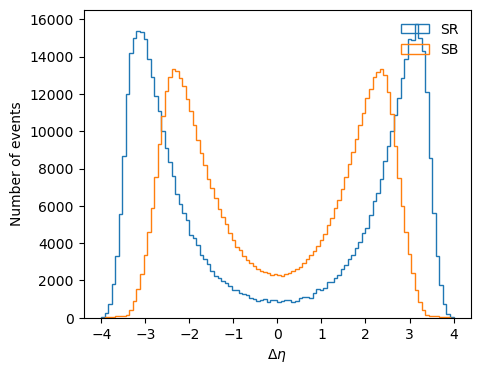

In [26]:
# plot Delta eta distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

n_bins = 100
hist_range = (-4, 4)

weight_b_SR = 1 / len(deta_b_SR) * np.ones_like(deta_b_SR) * n_eta_B
weight_b_SB = 1 / len(deta_b_SB) * np.ones_like(deta_b_SB) * n_eta_B
weight_s = 1 / len(deta_s) * np.ones_like(deta_s) * n_eta_S

ax.hist(deta_b_SR, bins=n_bins, range=hist_range, histtype='step', label='SR', weights=weight_b_SR)
ax.hist(deta_b_SB, bins=n_bins, range=hist_range, histtype='step', label='SB', weights=weight_b_SB)
# ax.hist(deta_s, bins=n_bins, range=hist_range, histtype='step', label='signal x 500', weights=weight_s * 500)

ax.set_xlabel('$\Delta \eta$')
ax.set_ylabel('Number of events')
ax.legend(frameon=False)

plt.show()

# Plot $m_{jj}$ distribution after CNN cut

In [26]:
def get_mjj_from_h5(h5_dirs: list, nevents: tuple, seed=0):
    # h5_dirs: list of npy directories
    # nevents: tuple of (n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB)
    mjj_SR, mjj_SB = [], []

    h5_dir0 = Path(h5_dirs[0])

    with h5py.File(h5_dir0 / 'sig_in_SR.h5', 'r') as f:
        size_sig_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'sig_in_SB.h5', 'r') as f:
        size_sig_SB = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'bkg_in_SR.h5', 'r') as f:
        size_bkg_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'bkg_in_SB.h5', 'r') as f:
        size_bkg_SB = f['EVENT/Mjj'][:].shape[0]

    n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB = nevents

    np.random.seed(seed)
    idx_sig_SR = np.random.choice(size_sig_SR, n_sig_SR, replace=False)
    idx_sig_SB = np.random.choice(size_sig_SB, n_sig_SB, replace=False)
    idx_bkg_SR = np.random.choice(size_bkg_SR, n_bkg_SR, replace=False)
    idx_bkg_SB = np.random.choice(size_bkg_SB, n_bkg_SB, replace=False)

    print(f'Preparing mjj from {h5_dirs}')
    for h5_dir in h5_dirs:
        h5_dir = Path(h5_dir)
        with h5py.File(h5_dir / 'sig_in_SR.h5', 'r') as f:
            mjj_SR.extend(f['EVENT/Mjj'][:][idx_sig_SR])
        with h5py.File(h5_dir / 'bkg_in_SR.h5', 'r') as f:
            mjj_SR.extend(f['EVENT/Mjj'][:][idx_bkg_SR])
        with h5py.File(h5_dir / 'sig_in_SB.h5', 'r') as f:
            mjj_SB.extend(f['EVENT/Mjj'][:][idx_sig_SB])
        with h5py.File(h5_dir / 'bkg_in_SB.h5', 'r') as f:
            mjj_SB.extend(f['EVENT/Mjj'][:][idx_bkg_SB])

    return np.array(mjj_SR), np.array(mjj_SB)


def get_deta_from_h5(h5_dirs: list, nevents: tuple, seed=0):
    # h5_dirs: list of npy directories
    # nevents: tuple of (n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB)
    deta_SR, deta_SB = [], []

    h5_dir0 = Path(h5_dirs[0])

    with h5py.File(h5_dir0 / 'sig_in_SR.h5', 'r') as f:
        size_sig_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'sig_in_SB.h5', 'r') as f:
        size_sig_SB = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'bkg_in_SR.h5', 'r') as f:
        size_bkg_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(h5_dir0 / 'bkg_in_SB.h5', 'r') as f:
        size_bkg_SB = f['EVENT/Mjj'][:].shape[0]

    n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB = nevents

    np.random.seed(seed)
    idx_sig_SR = np.random.choice(size_sig_SR, n_sig_SR, replace=False)
    idx_sig_SB = np.random.choice(size_sig_SB, n_sig_SB, replace=False)
    idx_bkg_SR = np.random.choice(size_bkg_SR, n_bkg_SR, replace=False)
    idx_bkg_SB = np.random.choice(size_bkg_SB, n_bkg_SB, replace=False)

    print(f'Preparing Delta eta from {h5_dirs}')
    for h5_dir in h5_dirs:
        h5_dir = Path(h5_dir)
        with h5py.File(h5_dir / 'sig_in_SR.h5', 'r') as f:
            pt1 = f['J1/pt'][:]
            pt2 = f['J2/pt'][:]
            jet1_eta = (f['J1/eta'][:] * pt1).sum(axis=1) / pt1.sum(axis=1)
            jet2_eta = (f['J2/eta'][:] * pt2).sum(axis=1) / pt2.sum(axis=1)
            print(jet1_eta, jet2_eta)
            deta = jet1_eta - jet2_eta
            deta_SR.extend(deta[idx_sig_SR])
        with h5py.File(h5_dir / 'bkg_in_SR.h5', 'r') as f:
            pt1 = f['J1/pt'][:]
            pt2 = f['J2/pt'][:]
            jet1_eta = (f['J1/eta'][:] * pt1).sum(axis=1) / pt1.sum(axis=1)
            jet2_eta = (f['J2/eta'][:] * pt2).sum(axis=1) / pt2.sum(axis=1)
            deta = jet1_eta - jet2_eta
            deta_SR.extend(deta[idx_bkg_SR])
        with h5py.File(h5_dir / 'sig_in_SB.h5', 'r') as f:
            pt1 = f['J1/pt'][:]
            pt2 = f['J2/pt'][:]
            jet1_eta = (f['J1/eta'][:] * pt1).sum(axis=1) / pt1.sum(axis=1)
            jet2_eta = (f['J2/eta'][:] * pt2).sum(axis=1) / pt2.sum(axis=1)
            deta = jet1_eta - jet2_eta
            deta_SB.extend(deta[idx_sig_SB])
        with h5py.File(h5_dir / 'bkg_in_SB.h5', 'r') as f:
            pt1 = f['J1/pt'][:]
            pt2 = f['J2/pt'][:]
            jet1_eta = (f['J1/eta'][:] * pt1).sum(axis=1) / pt1.sum(axis=1)
            jet2_eta = (f['J2/eta'][:] * pt2).sum(axis=1) / pt2.sum(axis=1)
            deta = jet1_eta - jet2_eta
            deta_SB.extend(deta[idx_bkg_SB])

    return np.array(deta_SR), np.array(deta_SB)

In [8]:
def get_mjj_from_npy(npy_dirs: list, nevents: tuple, seed=0):
    # npy_dirs: list of npy directories
    # nevents: tuple of (n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB)
    mjj_SR, mjj_SB = [], []

    np.random.seed(seed)
    n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB = nevents

    print(f'Preparing mjj from {npy_dirs}')
    for npy_dir in npy_dirs:
        npy_dir = Path(npy_dir)
        X, y = utils.load_samples(npy_dir)

        idx_sig_SR = np.random.choice(np.sum(y == 1), n_sig_SR, replace=False)
        idx_sig_SB = np.random.choice(np.sum(y == 1), n_sig_SB, replace=False)
        idx_bkg_SR = np.random.choice(np.sum(y == 0), n_bkg_SR, replace=False)
        idx_bkg_SB = np.random.choice(np.sum(y == 0), n_bkg_SB, replace=False)

        mjj_SR.extend(X[y == 1][idx_sig_SR])
        mjj_SR.extend(X[y == 0][idx_bkg_SR])
        mjj_SB.extend(X[y == 1][idx_sig_SB])
        mjj_SB.extend(X[y == 0][idx_bkg_SB])

    return np.array(mjj_SR), np.array(mjj_SB)

In [7]:
def get_thresholds_of_model(model_path, X, y, passing_rates=[0.01]):
    # return the threshold for a given false passing rate

    # save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
    loaded_model = tf.keras.models.load_model(model_path)
    
    # get the predicted probability
    y_prob = loaded_model.predict(X, batch_size=1024)
    fpr, th = utils.get_fpr_thresholds(y == 1, y_prob)

    thresholds = []
    for passing_rate in passing_rates:
        threshold = utils.get_threshold_from_fpr(fpr, th, passing_rate)
        thresholds.append(threshold)

    return thresholds

In [8]:
def get_mjj_after_CNN_cut(mjj, event_scores, labels, thresholds):
    # return the mjj passing the CNN cut for given thresholds

    mjj_s_CNN = []
    mjj_b_CNN = []

    for threshold in thresholds:
        y_preds = (event_scores > threshold).reshape(-1)

        mjj_s_CNN.append(mjj[(labels == 1) & (y_preds)])
        mjj_b_CNN.append(mjj[(labels == 0) & (y_preds)])

    return mjj_s_CNN, mjj_b_CNN

In [9]:
def get_ratio_and_std(n1, n2):
    ratio = np.divide(n1, n2)
    std = ratio * np.sqrt(1 / n1 + 1 / n2)
    return ratio, std

In [12]:
def plot_mjj_distribution_CNN_cut(mjj_b, mjj_b_CNNs, n_b_before_cut, efficiencies, n_bins=50, hist_range=(3500, 7000), save_path=None):
    # plot mjj distribution

    fig, ax = plt.subplots(2, 3, figsize=(15, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
    plt.subplots_adjust(wspace=0.3)
    titles = ['$\epsilon_\mathrm{SB}$ = ' + f'{eff * 100}%' for eff in efficiencies]

    for i in range(3):
        bkg_eff = efficiencies[i]

        mjj_b_CNN = mjj_b_CNNs[i]

        weight_b = 1 / mjj_b.shape[0] * np.ones_like(mjj_b) * n_b_before_cut
        weight_b_CNN = 1 / mjj_b_CNN.shape[0] * np.ones_like(mjj_b_CNN) * mjj_b_CNN.shape[0] / mjj_b.shape[0] * n_b_before_cut

        ax[0,i].hist(mjj_b, bins=n_bins, range=hist_range, histtype='step', label='$\eta$ cut, B', weights=weight_b)
        ax[0,i].hist(mjj_b_CNN, bins=n_bins, range=hist_range, histtype='step', label= f'CNN cut, B x {1 / bkg_eff:.0f}', weights=weight_b_CNN / bkg_eff)

        # get number in each bin
        n_mjj_b_CNN, edges_B = np.histogram(mjj_b_CNN, bins=n_bins, range=hist_range)
        n_mjj_b, edges_B = np.histogram(mjj_b, bins=n_bins, range=hist_range)

        # plot ratio
        ratio_B, ratio_std_B = get_ratio_and_std(n_mjj_b_CNN, n_mjj_b)

        ax[1,i].plot(edges_B[:-1], ratio_B, color='b', label='Background')
        ax[1,i].fill_between(edges_B[:-1], ratio_B - ratio_std_B, ratio_B + ratio_std_B, color='b', alpha=0.3)

        # 使用axvline函數繪製垂直線
        SRSB_region = [4400, 4700, 5500, 5800]
        ax[0,i].axvline(x=SRSB_region[1], color='r', linestyle=':')
        ax[0,i].axvline(x=SRSB_region[2], color='r', linestyle=':')
        ax[0,i].axvline(x=SRSB_region[0], color='g', linestyle=':')
        ax[0,i].axvline(x=SRSB_region[3], color='g', linestyle=':')
        ax[1,i].axvline(x=SRSB_region[1], color='r', linestyle=':')
        ax[1,i].axvline(x=SRSB_region[2], color='r', linestyle=':')
        ax[1,i].axvline(x=SRSB_region[0], color='g', linestyle=':')
        ax[1,i].axvline(x=SRSB_region[3], color='g', linestyle=':')

        ax[0,i].set_ylabel('Number of events')
        ax[0,i].set_title(titles[i])
        ax[0,i].legend(frameon=False)

        ax[1,i].axhline(y=bkg_eff, color='grey', linestyle='--')
        ax[1,i].set_xlabel('$m_{jj}$ [GeV]')
        ax[1,i].set_ylabel('$\epsilon_\mathrm{b}$')
        ax[1,i].set_yscale('log') 

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

In [10]:
def plot_deta_distribution_CNN_cut(mjj_b, mjj_b_CNNs, n_b_before_cut, efficiencies, n_bins=50, hist_range=(3500, 7000), save_path=None):
    # plot mjj distribution

    fig, ax = plt.subplots(2, 3, figsize=(15, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
    plt.subplots_adjust(wspace=0.3)
    titles = ['$\epsilon_\mathrm{SB}$ = ' + f'{eff * 100}%' for eff in efficiencies]

    for i in range(3):
        bkg_eff = efficiencies[i]

        mjj_b_CNN = mjj_b_CNNs[i]

        weight_b = 1 / mjj_b.shape[0] * np.ones_like(mjj_b) * n_b_before_cut
        weight_b_CNN = 1 / mjj_b_CNN.shape[0] * np.ones_like(mjj_b_CNN) * mjj_b_CNN.shape[0] / mjj_b.shape[0] * n_b_before_cut

        ax[0,i].hist(mjj_b, bins=n_bins, range=hist_range, histtype='step', label='$\eta$ cut, B', weights=weight_b)
        ax[0,i].hist(mjj_b_CNN, bins=n_bins, range=hist_range, histtype='step', label= f'CNN cut, B x {1 / bkg_eff:.0f}', weights=weight_b_CNN / bkg_eff)

        # get number in each bin
        n_mjj_b_CNN, edges_B = np.histogram(mjj_b_CNN, bins=n_bins, range=hist_range)
        n_mjj_b, edges_B = np.histogram(mjj_b, bins=n_bins, range=hist_range)

        # plot ratio
        ratio_B, ratio_std_B = get_ratio_and_std(n_mjj_b_CNN, n_mjj_b)

        ax[1,i].plot(edges_B[:-1], ratio_B, color='b', label='Background')
        ax[1,i].fill_between(edges_B[:-1], ratio_B - ratio_std_B, ratio_B + ratio_std_B, color='b', alpha=0.3)


        ax[0,i].set_ylabel('Number of events')
        ax[0,i].set_title(titles[i])
        ax[0,i].legend(frameon=False)

        ax[1,i].axhline(y=bkg_eff, color='grey', linestyle='--')
        ax[1,i].set_xlabel('$m_{jj}$ [GeV]')
        ax[1,i].set_ylabel('$\epsilon_\mathrm{b}$')
        ax[1,i].set_yscale('log') 

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

In [11]:
efficiencies = [0.1, 0.01, 0.001]
X_test_SB, y_test_SB = utils.load_samples('../Sample/HVmodel/data/split_val/25x25/mix_sample_test-SB.npy')

In [12]:
def from_npy_to_h5_dir(npy_dirs: list):
    # return the h5 path from npy path
    h5_dirs = [npy_path.replace('/25x25', '').replace('/75x75', '') for npy_path in npy_dirs]
    return h5_dirs

## Original

In [24]:
# load the model
model_name = 'SB_0.0_25x25'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

### Training dataset

In [14]:
config_file = 'config_files/origin_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0


Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing mjj from ['../Sample/HVmodel/data/origin']


In [15]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

2024-06-05 16:44:24.401860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


25/31 [=======================>......] - ETA: 0s

2024-06-05 16:44:25.994157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 0s 15ms/step


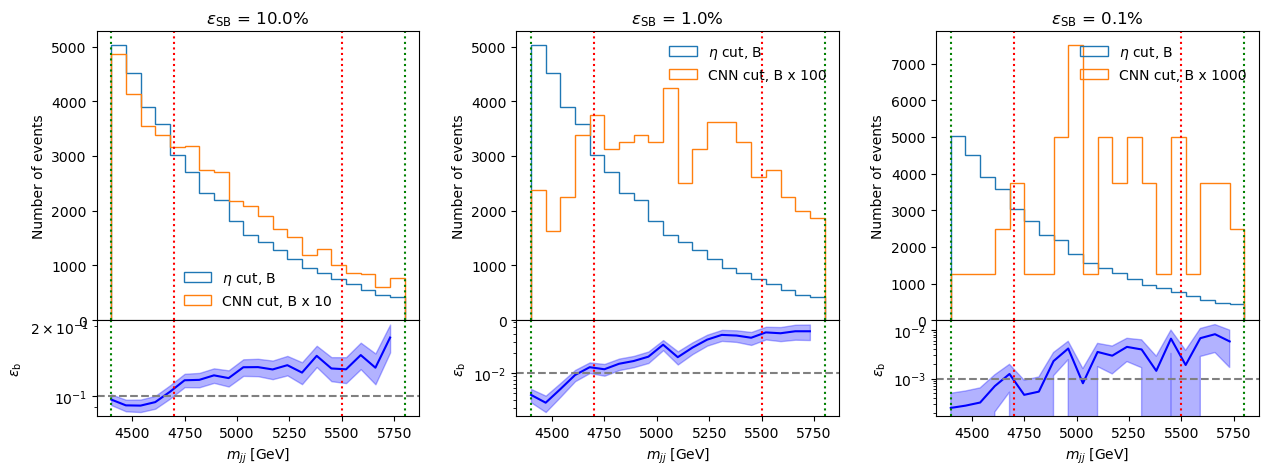

In [16]:
save_path = '../figures/mjj_distribution_CNN_cut_origin_SB_0_train.pdf'
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

### Testing

In [25]:
# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, X_test_SB, y_test_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

20/20 [==============================] - 0s 7ms/step


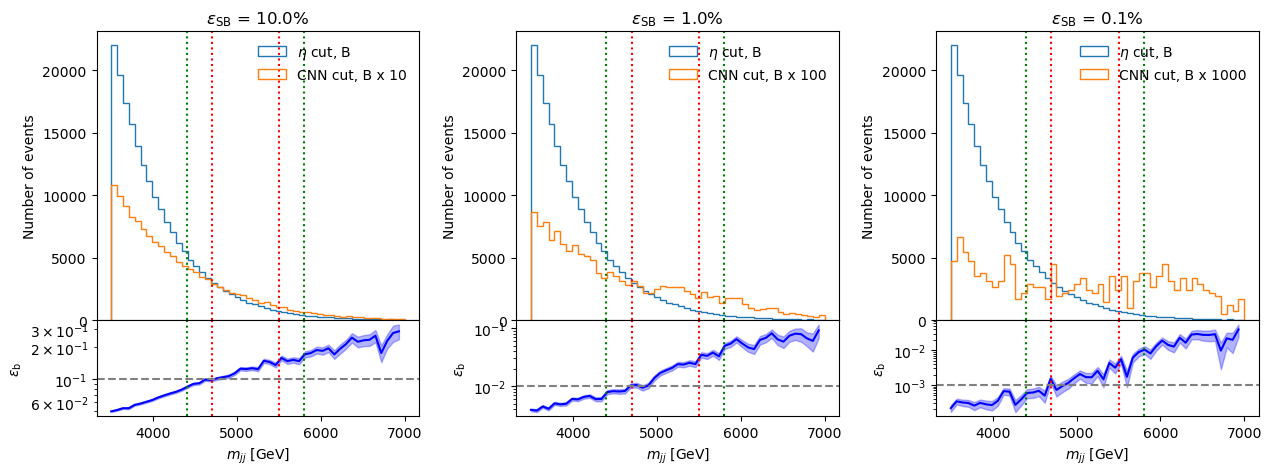

In [26]:
save_path = '../figures/mjj_distribution_CNN_cut_origin_SB_0_test.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path
                              )

## +3 Jet rotation

In [19]:
# load the model
model_name = 'SB_0.0_jet_aug_3_25x25'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

### Training dataset

In [20]:
config_file = 'config_files/jet_aug_3_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25', '../Sample/HVmodel/data/jet_rotation/25x25/01', '../Sample/HVmodel/data/jet_rotation/25x25/02', '../Sample/HVmodel/data/jet_rotation/25x25/03']
Preparing mjj from ['../Sample/HVmodel/data/origin', '../Sample/HVmodel/data/jet_rotation/01', '../Sample/HVmodel/data/jet_rotation/02', '../Sample/HVmodel/data/jet_rotation/03']


In [21]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

64/64 [==============================] - 1s 8ms/step


/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)


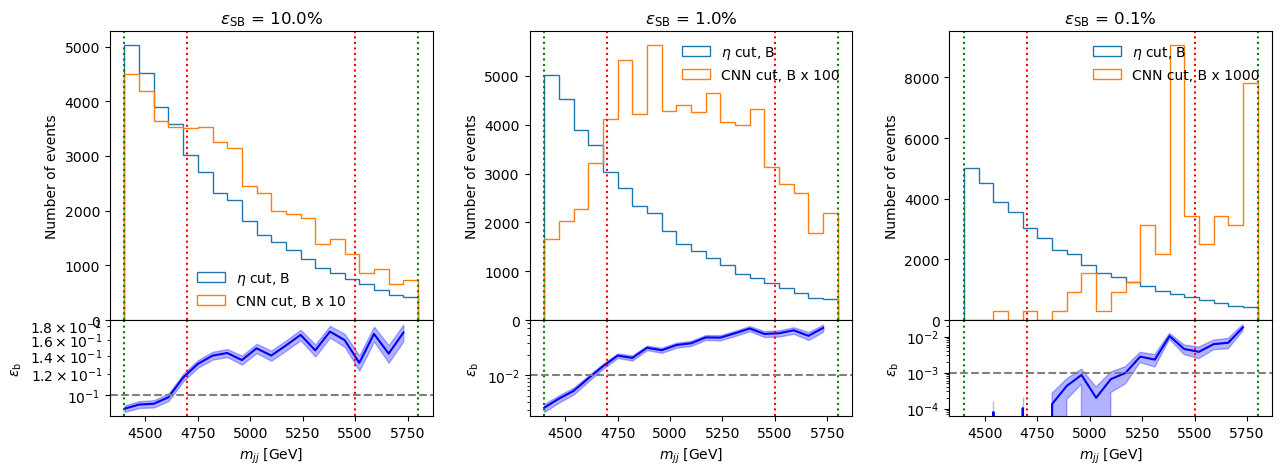

In [22]:
save_path = '../figures/mjj_distribution_CNN_cut_jet_aug_3_SB_0_train.pdf'
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

### Testing dataset

In [23]:
# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, X_test_SB, y_test_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

20/20 [==============================] - 0s 7ms/step


/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)


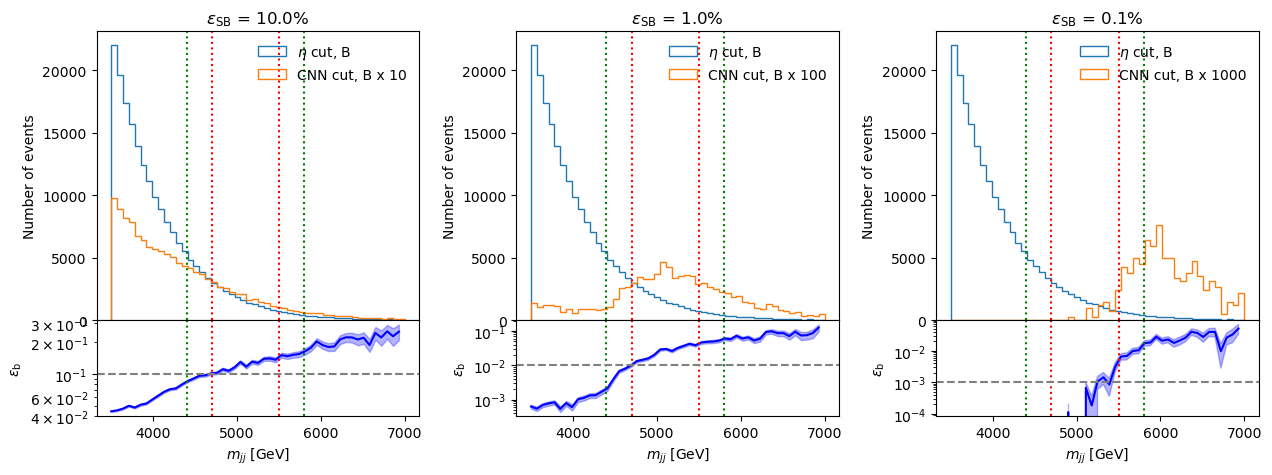

In [24]:
save_path = '../figures/mjj_distribution_CNN_cut_jet_aug_3_SB_0_test.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path
                              )

## +3 $p_\text{T}$ smearing + Jet rotation

In [25]:
# load the model
model_name = 'SB_0.0_pt_jet_aug_3_25x25'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

### Training dataset

In [26]:
config_file = 'config_files/pt_jet_aug_3_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/01', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/02', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/03']
Preparing mjj from ['../Sample/HVmodel/data/origin', '../Sample/HVmodel/data/pt_smearing_jet_rotation/01', '../Sample/HVmodel/data/pt_smearing_jet_rotation/02', '../Sample/HVmodel/data/pt_smearing_jet_rotation/03']


In [27]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

64/64 [==============================] - 1s 7ms/step


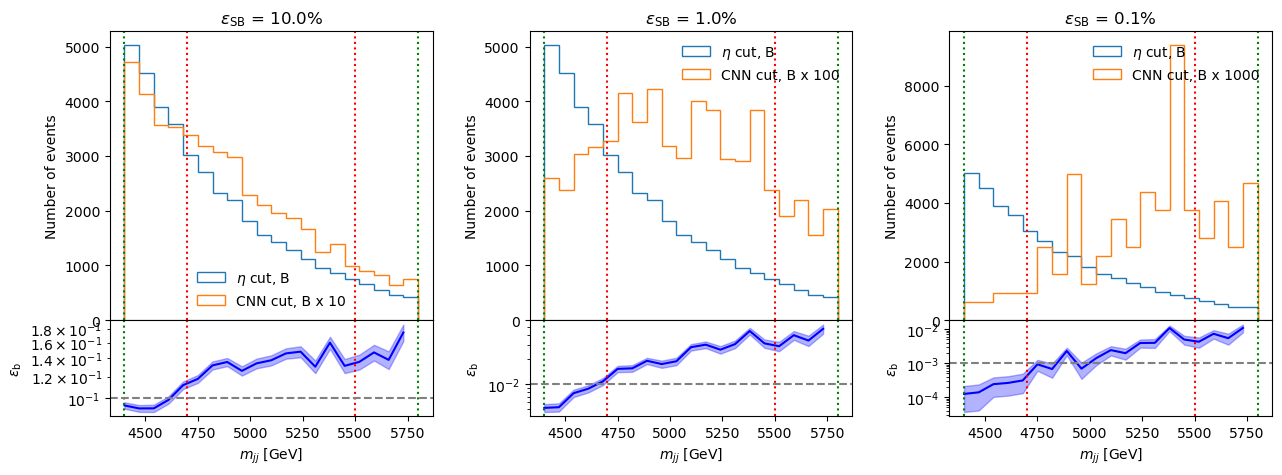

In [28]:
save_path = '../figures/mjj_distribution_CNN_cut_pt_jet_aug_3_SB_0_train.pdf'
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

### Testing dataset

In [29]:
# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, X_test_SB, y_test_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

20/20 [==============================] - 0s 7ms/step


/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_2304920/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)


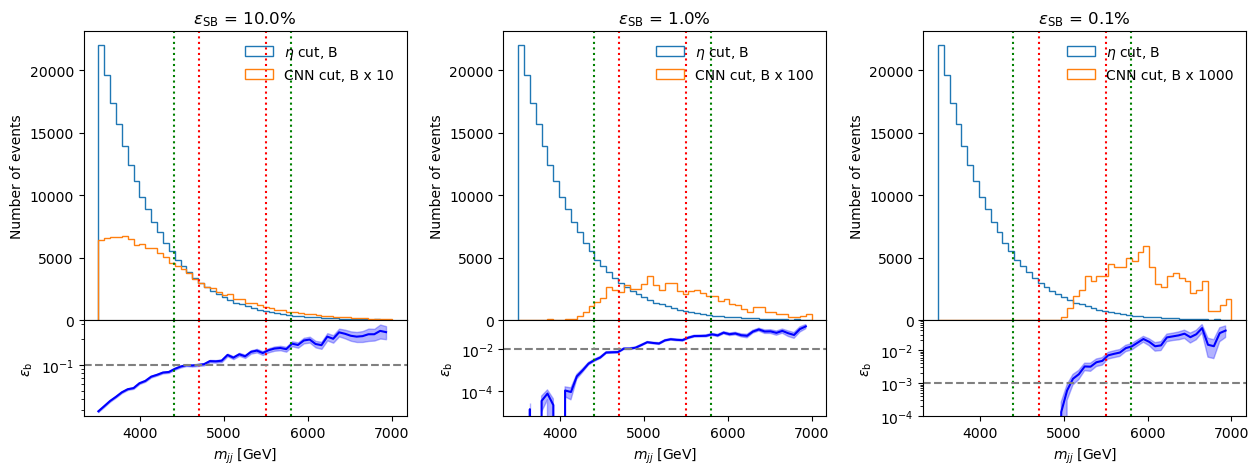

In [30]:
save_path = '../figures/mjj_distribution_CNN_cut_pt_jet_aug_3_SB_0_test.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path)

## $m_{jj}$ normalization

In [11]:
# load the model
model_name = 'SB_0.0_25x25_pt_nor'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

2024-08-09 16:31:30.417294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 16:31:30.992824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [12]:
config_file = 'config_files/pt_normalize_25x25_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/pt_normalization/25x25']
Preparing mjj from ['../Sample/HVmodel/data/pt_normalization']


In [13]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

2024-08-09 16:31:35.788956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


25/31 [=======================>......] - ETA: 0s

2024-08-09 16:31:37.382168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 0s 15ms/step


/tmp/ipykernel_2320644/1507950327.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1 / n1 + 1 / n2)
/tmp/ipykernel_2320644/1507950327.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1 / n1 + 1 / n2)


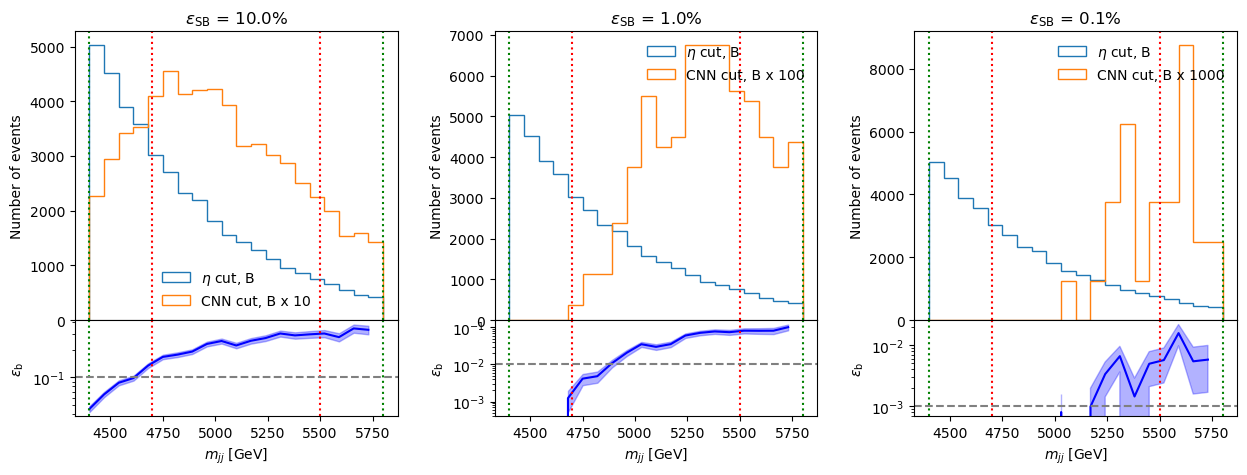

In [15]:
save_path = '../figures/mjj_distribution_CNN_cut_pt_normalized_origin_SB_0_train.pdf'
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

## SRSB normalization

In [33]:
# load the model
model_name = 'SB_0.0_25x25_SRSB_norm'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

In [34]:
config_file = 'config_files/SRSB_normalize_25x25_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)
val_npy_paths = config['val_npy_paths']

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing mjj from ['../Sample/HVmodel/data/origin']


In [35]:
# compute the mean and std of the training set, then normalize the training set
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)
X_train, y_train = utils.create_mix_sample_from_npy(train_npy_paths, train_nevents, seed=seed)

val_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_val).astype(int)
X_val, y_val = utils.create_mix_sample_from_npy(val_npy_paths, val_nevents, seed=seed)

X_SR = np.concatenate([X_train[y_train == 1], X_val[y_val == 1]])
X_SB = np.concatenate([X_train[y_train == 0], X_val[y_val == 0]])

mean_SR, std_SR = np.mean(X_SR), np.std(X_SR)
mean_SB, std_SB = np.mean(X_SB), np.std(X_SB)

X_train_SR = (X_train_SR - mean_SR) / std_SR
X_train_SB = (X_train_SB - mean_SB) / std_SB

Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25/val']


In [36]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

16/16 [==============================] - 0s 7ms/step


/tmp/ipykernel_985713/1507950327.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1 / n1 + 1 / n2)
/tmp/ipykernel_985713/1507950327.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1 / n1 + 1 / n2)


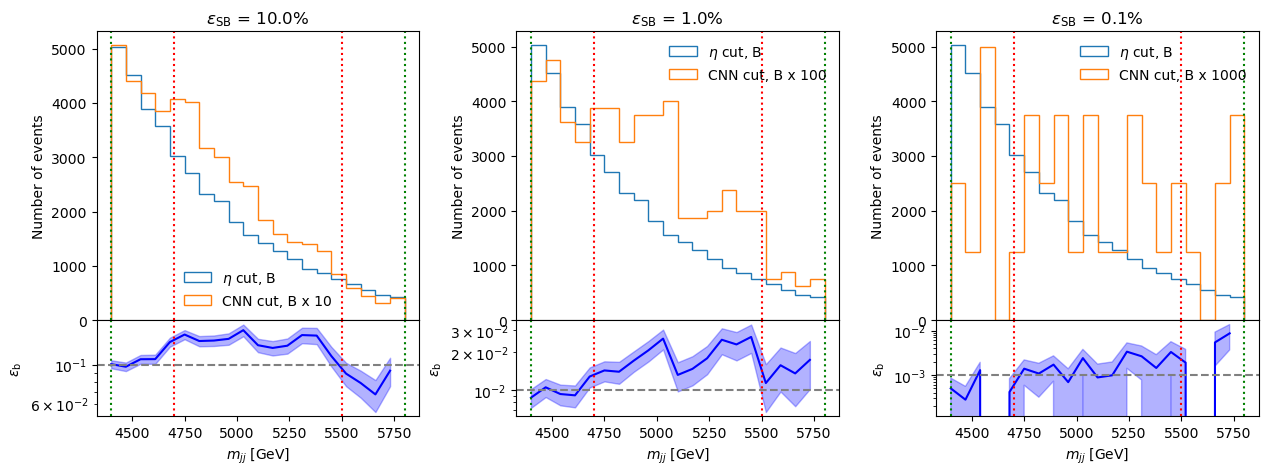

In [15]:
save_path = '../figures/mjj_distribution_CNN_cut_SRSB_normalized_origin_SB_0_train.pdf'
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

## $p_{\text{T}}$ normalization

In [13]:
def image_pt_normlization(X):
    # input shape: (n, res, res, 2)
    return (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)


def event_pt_normlization(X):
    # input shape: (n, res, res, 2)
    return (X - X.mean(axis=(1, 2, 3), keepdims=True)) / X.std(axis=(1, 2, 3), keepdims=True)

In [14]:
# load the model
model_name = 'SB_0.0_25x25_image_pT_norm'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

2024-10-08 15:50:46.832849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 15:50:47.422581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [15]:
config_file = 'config_files/image_pT_normalize_25x25_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)
val_npy_paths = config['val_npy_paths']

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

X_train_SR = image_pt_normlization(X_train_SR)
X_train_SB = image_pt_normlization(X_train_SB)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing mjj from ['../Sample/HVmodel/data/origin']


In [16]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

2024-10-08 15:51:11.774739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


24/31 [======================>.......] - ETA: 0s

2024-10-08 15:51:16.181769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 0s 15ms/step


/tmp/ipykernel_2107959/1507950327.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1 / n1 + 1 / n2)
/tmp/ipykernel_2107959/1507950327.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1 / n1 + 1 / n2)


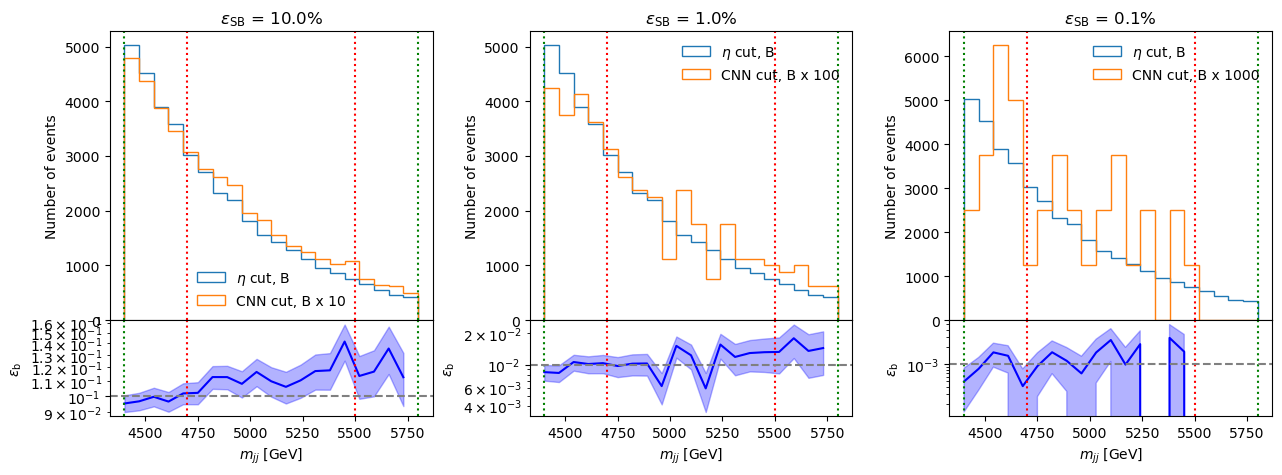

In [17]:
# save_path = '../figures/mjj_distribution_CNN_cut_image_pT_normalized_origin_SB_0_train.pdf'
save_path = None
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

In [18]:
X_image_norm = image_pt_normlization(X)

/tmp/ipykernel_2107959/448723443.py:3: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)


In [19]:
# get the predicted probability
y_prob = loaded_model.predict(X_image_norm, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, image_pt_normlization(X_test_SB), y_test_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

20/20 [==============================] - 0s 12ms/step


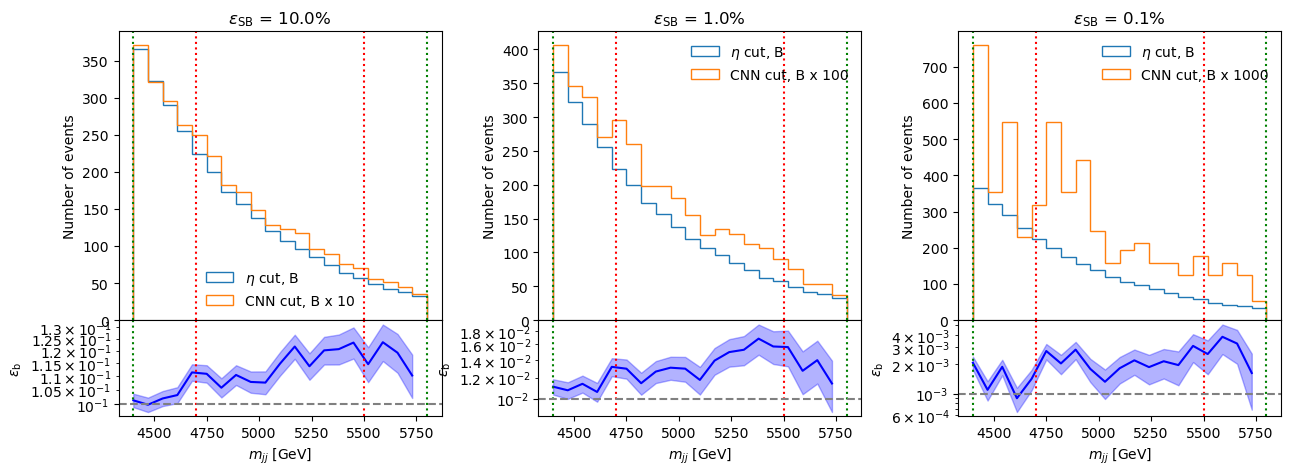

In [20]:
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=None
                              )

In [21]:
# load the model
model_name = 'SB_0.0_25x25_event_pT_norm'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

In [22]:
config_file = 'config_files/event_pT_normalize_25x25_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)
val_npy_paths = config['val_npy_paths']

seed = config['seed']
sensitivity = config['sensitivity']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)

X_train_SR = event_pt_normlization(X_train_SR)
X_train_SB = event_pt_normlization(X_train_SB)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing mjj from ['../Sample/HVmodel/data/origin']


In [23]:
X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

# get the threshold from the training samples in SB region
thresholds = get_thresholds_of_model(model_path, X_train_SB, y_train_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)

16/16 [==============================] - 0s 7ms/step


/tmp/ipykernel_2107959/1507950327.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1 / n1 + 1 / n2)
/tmp/ipykernel_2107959/1507950327.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1 / n1 + 1 / n2)


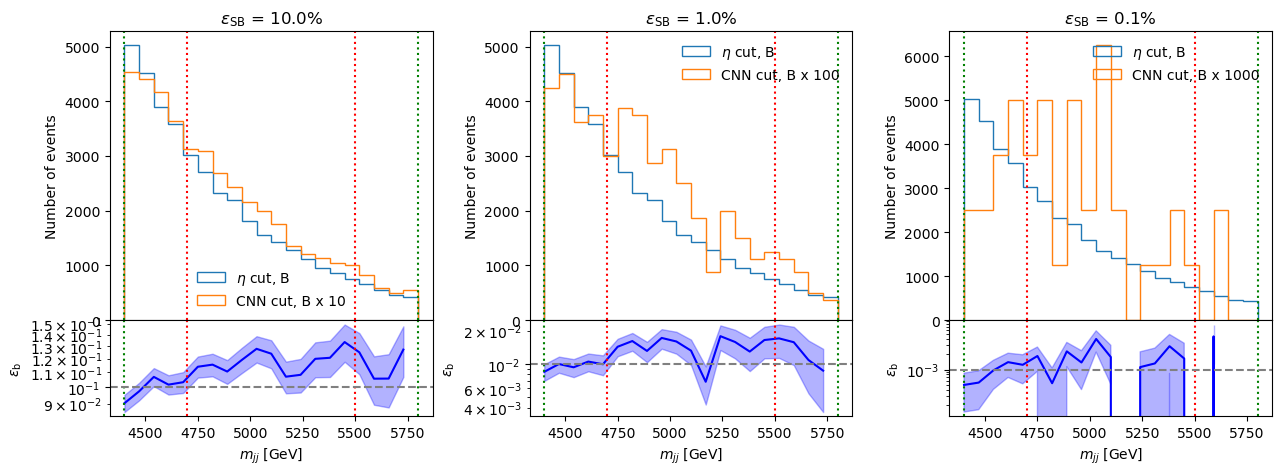

In [24]:
save_path = '../figures/mjj_distribution_CNN_cut_event_pT_normalized_origin_SB_0_train.pdf'
save_path = None
plot_mjj_distribution_CNN_cut(mjj_train_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=save_path
                              )

In [25]:
X_event_norm = event_pt_normlization(X)

In [28]:
# get the predicted probability
y_prob = loaded_model.predict(X_event_norm, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, event_pt_normlization(X_test_SB), y_test_SB, passing_rates=efficiencies)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

20/20 [==============================] - 0s 7ms/step


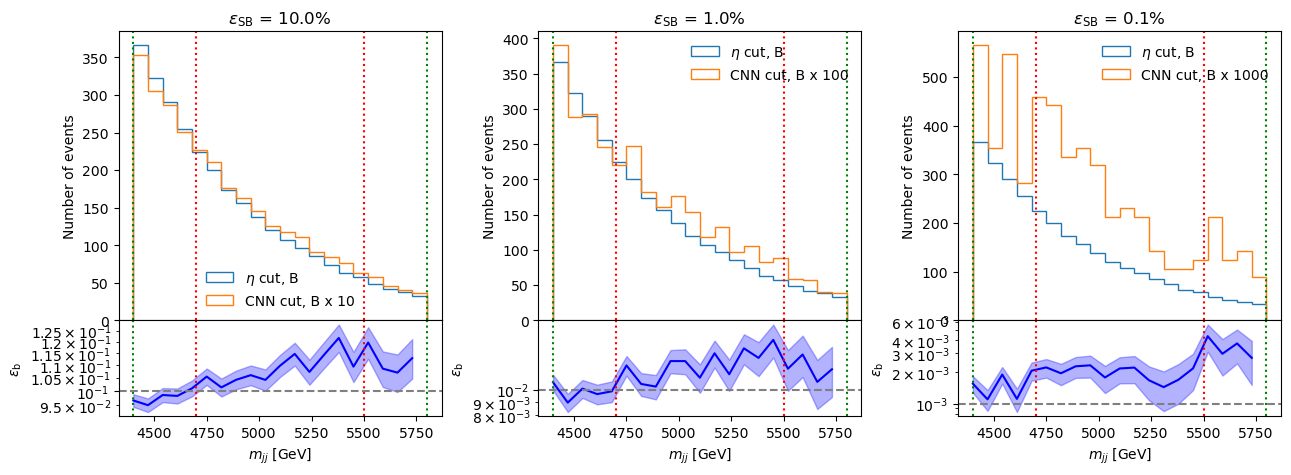

In [29]:
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=20,
                              hist_range=(4400, 5800),
                              save_path=None
                              )

## Plot $\Delta\eta$ distribution

In [13]:
def image_pt_normlization(X):
    # input shape: (n, res, res, 2)
    return (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)


def event_pt_normlization(X):
    # input shape: (n, res, res, 2)
    return (X - X.mean(axis=(1, 2, 3), keepdims=True)) / X.std(axis=(1, 2, 3), keepdims=True)

In [14]:
# load the model
model_name = 'SB_0.0_25x25_image_pT_norm'
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

2024-10-09 13:34:58.790445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 13:34:59.505836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [27]:
config_file = 'config_files/image_pT_normalize_25x25_config_01.json'
with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = from_npy_to_h5_dir(train_npy_paths)
val_npy_paths = config['val_npy_paths']

seed = config['seed']
sensitivity = config['sensitivity']


# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)
train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)

X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)
deta_SR, deta_SB = get_deta_from_h5(train_h5_paths, train_nevents, seed=seed)

X_train_SR = image_pt_normlization(X_train_SR)
X_train_SB = image_pt_normlization(X_train_SB)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing Delta eta from ['../Sample/HVmodel/data/origin']
[ 1.2956368e-08  4.1476401e-08 -1.6794884e-08 ... -3.8057298e-08
  7.1232392e-10 -1.6991324e-07] [ 4.7847031e-08 -7.9961616e-08  6.5608091e-08 ...  4.1072003e-08
 -8.6687784e-08 -1.5179280e-07]


In [15]:
X_image_norm = image_pt_normlization(X)

/tmp/ipykernel_2120498/448723443.py:3: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)


In [16]:
# get the predicted probability
y_prob = loaded_model.predict(X_image_norm, batch_size=1024)

# determine the threshold from the sideband region
thresholds = get_thresholds_of_model(model_path, image_pt_normlization(X_test_SB), y_test_SB, passing_rates=efficiencies)

deta_s_CNNs, deta_b_CNNs = get_mjj_after_CNN_cut(deta, y_prob, y, thresholds)

2024-10-09 13:37:12.975527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


  24/2340 [..............................] - ETA: 16s  

2024-10-09 13:37:14.605137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 0s 12ms/step


/tmp/ipykernel_2120498/1507950327.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1 / n1 + 1 / n2)
/tmp/ipykernel_2120498/1507950327.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1 / n1 + 1 / n2)


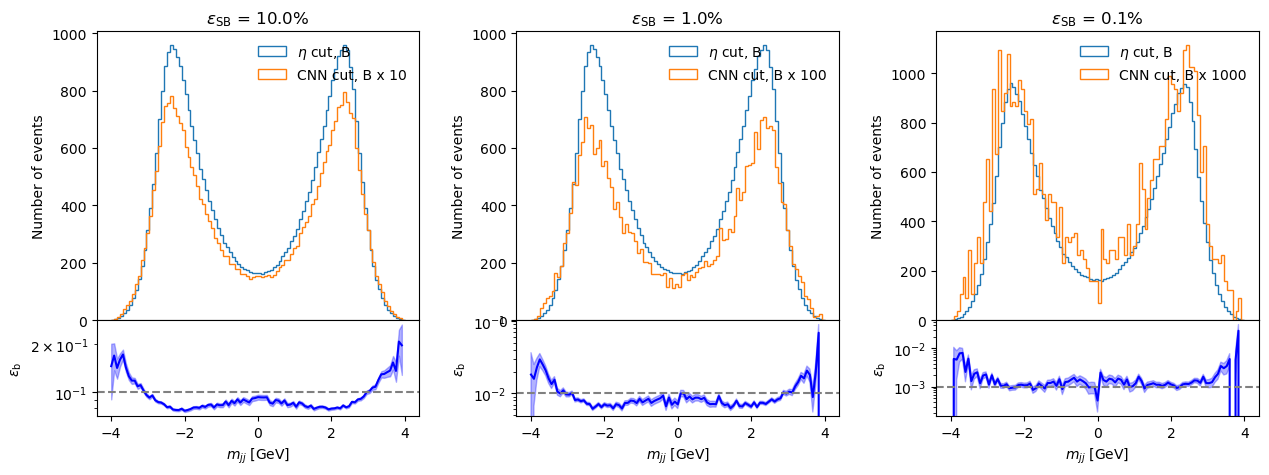

In [19]:
plot_deta_distribution_CNN_cut(deta_b,
                              deta_b_CNNs,
                              n_b_before_cut=n_SR_B + n_SB_B,
                              efficiencies=efficiencies,
                              n_bins=100,
                              hist_range=(-4, 4),
                              save_path=None
                              )